# Time Series Prediction

**Objectives**
 1. Learn how to build a Keras model for time series prediction and deploy on AI Platform
 
In this lab we will build a custom Keras model

In [56]:
import datetime
import os
import shutil

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, DenseFeatures,
                                     SimpleRNN, Reshape, LSTM)
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

# To plot pretty figures
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [57]:
PROJECT = "munn-sandbox"  # Replace with your PROJECT
BUCKET = "munn-sandbox"  # Replace with your BUCKET
REGION = "us-east1"            # Choose an available region for Cloud MLE
#PROJECT = "cloud-training-demos"  # Replace with your PROJECT
#BUCKET = ""cloud-training-demos-ml"  # Replace with your BUCKET
#REGION = "us-central1"            # Choose an available region for Cloud MLE

In [58]:
os.environ["PROJECT"] = PROJECT
os.environ["BUCKET"] = BUCKET
os.environ["REGION"] = REGION

In [ ]:
from google.cloud import bigquery
bq = bigquery.Client(project=PROJECT)

bq_query = '''
#standardSQL
SELECT
  symbol,
  Date,
  direction,
  close_values_prior_260
FROM
  `stock_market.percent_change_sp500`
LIMIT
  1000
'''

df_stock_raw = bq.query(bq_query).to_dataframe()

In [ ]:
df_stock_raw.head()

In [ ]:
def clean_data(input_df):
    df = input_df.copy()

    # Remove inf/na values.
    real_valued_rows = ~(df == np.inf).max(axis=1)
    df = df[real_valued_rows].dropna()

    # TF doesn't accept datetimes in DataFrame.
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')

    # TF requires numeric label.
    df['direction_numeric'] = df['direction'].apply(lambda x: {'DOWN': 0,
                                                               'STAY': 1,
                                                               'UP': 2}[x])
    return df

In [ ]:
df_stock = clean_data(df_stock_raw)

In [ ]:
df_stock.head()

## Read data and preprocessing

In [ ]:
STOCK_HISTORY_COLUMN = 'close_values_prior_260'
COL_NAMES = ['day_' + str(day) for day in range(0, 260)]
LABEL = 'direction_numeric'

In [15]:
def _scale_features(features):
    """z-scale features."""
    avg = features.mean().mean()
    std = features.std().mean()
    return (features - avg)/std

In [16]:
def create_features(df, label_name):
    # Expand 1 column containing a list of close prices to 260 columns.
    time_series_features = df[STOCK_HISTORY_COLUMN].apply(pd.Series)

    # Rename columns.
    time_series_features.columns = COL_NAMES
    time_series_features = _scale_features(time_series_features)

    # Concat time series features with static features and label.
    label_column = df[LABEL]

    return pd.concat([time_series_features,
                      label_column], axis=1)

In [17]:
df_features = create_features(df_stock, LABEL)

In [18]:
df_features.head()

,day_0,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,...,day_251,day_252,day_253,day_254,day_255,day_256,day_257,day_258,day_259,direction_numeric
0,-0.042816,-0.039033,-0.050146,-0.046600,-0.048964,-0.055112,-0.056530,-0.055112,-0.037851,-0.036432,...,-0.298182,-0.307403,-0.315679,-0.306457,-0.274537,-0.275719,-0.250655,-0.204075,-0.133613,2
1,0.335266,0.357729,0.362221,0.366477,0.360566,0.380664,0.386339,0.372861,0.381137,0.383974,...,0.158165,0.143033,0.153200,0.149653,0.149890,0.168806,0.165259,0.169042,0.156983,1
2,0.787593,0.778608,0.751890,0.750471,0.736993,0.726353,0.711220,0.739594,0.752835,0.715003,...,-0.211641,-0.213533,-0.213533,-0.190361,-0.231503,-0.227956,-0.246163,-0.244035,-0.289669,0
3,-0.452110,-0.454238,-0.452110,-0.456366,-0.458494,-0.458494,-0.454238,-0.458494,-0.452110,-0.436741,...,-0.359186,-0.347127,-0.327738,-0.322772,-0.327738,-0.349491,-0.349491,-0.349491,-0.349491,1
4,1.094032,1.183173,1.198779,1.268768,1.244886,1.186956,1.265930,1.344668,1.362638,1.415603,...,0.170697,0.180155,0.240686,0.204273,-0.006403,0.098817,0.165022,0.143506,0.257947,0


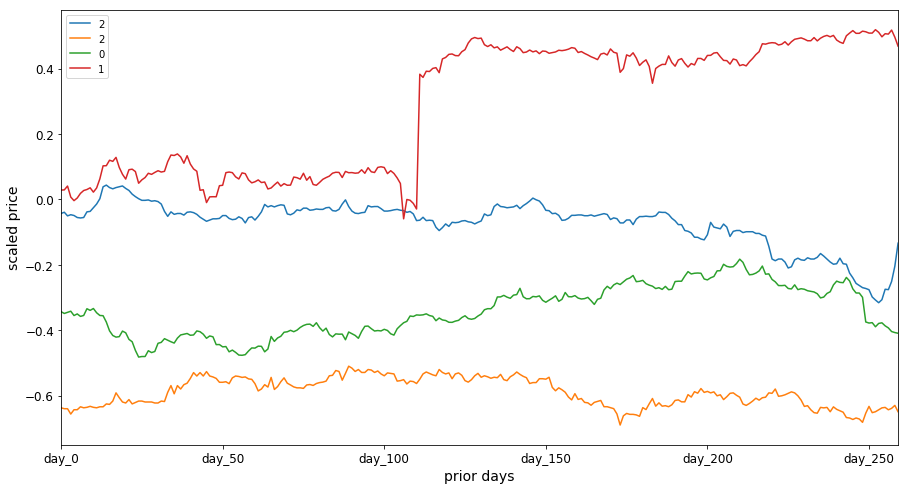

In [19]:
from matplotlib import pyplot as plt
ix_to_plot = [0, 10, 99, 555]
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
for ix in ix_to_plot:
    label = df_features['direction_numeric'].iloc[ix]
    example = df_features[COL_NAMES].iloc[ix]
    ax = example.plot(label=label, ax=ax)
    ax.set_ylabel('scaled price')
    ax.set_xlabel('prior days')
    ax.legend()

### Make train-eval-test split

In [20]:
def create_query(phase, sample_size):
    basequery = """
    SELECT
      symbol,
      Date,
      direction,
      close_values_prior_260
    FROM
      `stock_market.percent_change_sp500`
    WHERE MOD(ABS(FARM_FINGERPRINT(CAST(Date AS STRING))), EVERY_N) = 1
    """

    if phase == "TRAIN":
        subsample = """
        AND MOD(ABS(FARM_FINGERPRINT(CAST(Date AS STRING))), EVERY_N * 100) >= (EVERY_N * 0)
        AND MOD(ABS(FARM_FINGERPRINT(CAST(Date AS STRING))), EVERY_N * 100) <  (EVERY_N * 70)
        """
    elif phase == "VALID":
        subsample = """
        AND MOD(ABS(FARM_FINGERPRINT(CAST(Date AS STRING))), EVERY_N * 100) >= (EVERY_N * 70)
        AND MOD(ABS(FARM_FINGERPRINT(CAST(Date AS STRING))), EVERY_N * 100) <  (EVERY_N * 85)
        """
    elif phase == "TEST":
        subsample = """
        AND MOD(ABS(FARM_FINGERPRINT(CAST(Date AS STRING))), EVERY_N * 100) >= (EVERY_N * 85)
        AND MOD(ABS(FARM_FINGERPRINT(CAST(Date AS STRING))), EVERY_N * 100) <  (EVERY_N * 100)
        """

    query = basequery + subsample
    return query.replace("EVERY_N", sample_size)

In [21]:
bq = bigquery.Client(project=PROJECT)

for phase in ['TRAIN', 'VALID', 'TEST']:
    # 1. Create query string
    query_string = create_query(phase, '250')
    # 2. Load results into DataFrame
    df = bq.query(query_string).to_dataframe()

    # 3. Clean, preprocess dataframe
    df = clean_data(df)
    df = create_features(df, label_name='direction_numeric')

    # 3. Write DataFrame to CSV
    if not os.path.exists('./data'):
        os.mkdir('./data')
    df.to_csv('./data/stock-{}.csv'.format(phase.lower()),
              index_label=False, index=False)
    print("Wrote {} lines to {}".format(
        len(df),
        './data/stock-{}.csv'.format(phase.lower())))

Wrote 6697 lines to ./data/stock-train.csv
Wrote 2508 lines to ./data/stock-valid.csv
Wrote 1752 lines to ./data/stock-test.csv


In [22]:
ls -la ./data

total 55564
drwxr-xr-x  2 jupyter jupyter     4096 Oct 22 16:30 ./
drwxr-xr-x 10 jupyter jupyter     4096 Oct 22 20:29 ../
-rw-r--r--  1 jupyter jupyter  9100104 Oct 22 20:30 stock-test.csv
-rw-r--r--  1 jupyter jupyter 34793180 Oct 22 20:29 stock-train.csv
-rw-r--r--  1 jupyter jupyter 12990239 Oct 22 20:30 stock-valid.csv


## Modeling

In [23]:
CSV_COLUMNS = COL_NAMES + [LABEL]
DEFAULTS = [[0.0]]*len(COL_NAMES) + [[0]]

def features_and_labels(row_data):
    fields = tf.io.decode_csv(records=row_data, record_defaults=DEFAULTS)
    features = dict(zip(CSV_COLUMNS, fields))
    label = features.pop(LABEL)
        
    return features, label


def create_dataset(pattern, batch_size=1, mode=tf.estimator.ModeKeys.EVAL):
    dataset = tf.data.TextLineDataset(filenames=pattern).skip(count = 1) # skip header

    dataset = dataset.map(map_func=features_and_labels)
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        dataset = dataset.shuffle(buffer_size=1000).repeat(None).batch(batch_size)
    else:
        dataset = dataset.repeat(1).batch(batch_size)

    # take advantage of multi-threading; 1=AUTOTUNE
    dataset = dataset.prefetch(1)
    return dataset

In [24]:
# Create input layer of feature columns
feature_columns = {
    colname: tf.feature_column.numeric_column(colname)
    for colname in COL_NAMES
    }

In [25]:
BATCH_SIZE=100
NUM_EXAMPLES=7000
NUM_EPOCHS=30

N_TIME_STEPS = 260
N_LABELS = 3

In [26]:
def fit_model(model, batch_size, num_epochs, logdir):

    # Create train and validation datasets.
    get_train = create_dataset(pattern='./data/stock-train.csv',
                               batch_size=batch_size,
                               mode=tf.estimator.ModeKeys.TRAIN)
    get_valid = create_dataset(pattern='./data/stock-valid.csv',
                               batch_size=batch_size,
                               mode=tf.estimator.ModeKeys.EVAL)

    # Create the model.
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['categorical_accuracy'])

    # Collect callback for training.
    callbacks = [
      # Save model after every epoch
      ModelCheckpoint(filepath=logdir, monitor='val_loss'),
      # Write TensorBoard logs output directory
      TensorBoard(log_dir=logdir)
    ]
    
    history = model.fit(x=get_train,
                        epochs=num_epochs,
                        steps_per_epoch=NUM_EXAMPLES//(batch_size*num_epochs),
                        validation_data=get_valid,
                        callbacks=callbacks)
    return history

In [27]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    #plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

In [50]:
def plot_accuracy_curves(categorical_acc, val_catigorical_acc):
    plt.plot(np.arange(len(categorical_acc)) + 0.5,
             categorical_acc,
             "b.-", label="Training accuracy")
    plt.plot(np.arange(len(val_catigorical_acc)) + 1,
             categorical_acc, "r.-",
             label="Validation accuracy")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)    

### Linear model

In [28]:
def linear_model():
    model = Sequential()
    model.add(DenseFeatures(feature_columns=feature_columns.values()))
    
    model.add(Dense(units=N_LABELS, activation="softmax"))
    
    return model

In [ ]:
%%time
LOGDIR = './stock_linear_trained'

linear_results = fit_model(model = linear_model(),
                           batch_size=BATCH_SIZE,
                           num_epochs=NUM_EPOCHS,
                           logdir=LOGDIR)

Epoch 1/30


W1022 20:53:09.502495 139851340015360 summary_ops_v2.py:1161] Trace already enabled


1/2 [==============>...............] - ETA: 4s - loss: 3.6309 - categorical_accuracy: 0.3300

W1022 20:53:16.609543 139851340015360 callbacks.py:243] Method (on_train_batch_end) is slow compared to the batch update (3.534486). Check your callbacks.


2/2 [==============================] - 24s 12s/step - loss: 3.6429 - categorical_accuracy: 0.3067 - val_loss: 3.3077 - val_categorical_accuracy: 0.3856
Epoch 2/30
2/2 [==============================] - 9s 5s/step - loss: 3.6030 - categorical_accuracy: 0.3267 - val_loss: 3.3708 - val_categorical_accuracy: 0.3668
Epoch 3/30
2/2 [==============================] - 9s 5s/step - loss: 3.3573 - categorical_accuracy: 0.2967 - val_loss: 3.3036 - val_categorical_accuracy: 0.2002
Epoch 4/30
2/2 [==============================] - 42s 21s/step - loss: 2.9535 - categorical_accuracy: 0.1900 - val_loss: 3.2709 - val_categorical_accuracy: 0.2245
Epoch 5/30
1/2 [==============>...............] - ETA: 2s - loss: 3.2811 - categorical_accuracy: 0.1700

In [ ]:
plot_learning_curves(linear_results.history["loss"],
                     linear_results.history["val_loss"])
plt.show()

In [ ]:
plot_accuracy_curves(linear_results.history["categorical_accuracy"],
                     linear_results.history["val_categorical_accuracy"])
plt.show()

### DNN model

In [31]:
def dnn_model(dnn_hidden_units):
    model = Sequential()
    model.add(DenseFeatures(feature_columns=feature_columns.values()))

    for layer in dnn_hidden_units:
        model.add(Dense(units=layer, activation="relu"))

    model.add(Dense(units=N_LABELS, activation="softmax"))

    return model

In [32]:
%%time
LOGDIR = './stock_dnn_trained'

if os.path.exists(LOGDIR):
    shutil.rmtree(LOGDIR)

dnn_results = fit_model(model=dnn_model(dnn_hidden_units=[128, 64, 32, 8, 5]),
                        batch_size=BATCH_SIZE,
                        num_epochs=NUM_EPOCHS,
                        logdir=LOGDIR)

Epoch 1/30
2/2 [==============================] - 17s 8s/step - loss: 3.6267 - categorical_accuracy: 0.0000e+00 - val_loss: 3.1812 - val_categorical_accuracy: 0.0016
Epoch 2/30
2/2 [==============================] - 10s 5s/step - loss: 3.4536 - categorical_accuracy: 0.0000e+00 - val_loss: 3.1615 - val_categorical_accuracy: 0.0239
Epoch 3/30
2/2 [==============================] - 10s 5s/step - loss: 3.2334 - categorical_accuracy: 0.0567 - val_loss: 3.1687 - val_categorical_accuracy: 0.1579
Epoch 4/30
2/2 [==============================] - 15s 8s/step - loss: 2.8911 - categorical_accuracy: 0.3533 - val_loss: 3.1635 - val_categorical_accuracy: 0.5148
Epoch 5/30
2/2 [==============================] - 10s 5s/step - loss: 3.2200 - categorical_accuracy: 0.6333 - val_loss: 3.1649 - val_categorical_accuracy: 0.6049
Epoch 6/30
2/2 [==============================] - 10s 5s/step - loss: 3.3313 - categorical_accuracy: 0.7333 - val_loss: 3.1613 - val_categorical_accuracy: 0.6886
Epoch 7/30
2/2 [====

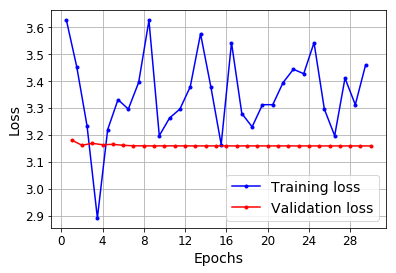

In [33]:
plot_learning_curves(dnn_results.history["loss"], dnn_results.history["val_loss"])
plt.show()

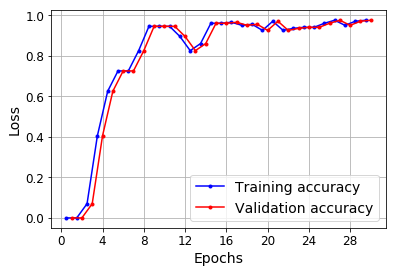

In [53]:
plot_accuracy_curves(history.history["categorical_accuracy"],
                     history.history["val_categorical_accuracy"])
plt.show()

### CNN model

In [34]:
def cnn_model():
    model = Sequential()
    model.add(DenseFeatures(feature_columns=feature_columns.values()))

    # First convolutional layer
    model.add(Reshape(target_shape=[N_TIME_STEPS, 1]))
    model.add(tf.keras.layers.Conv1D(filters=20,
                                     kernel_size=4,
                                     strides=2,
                                     padding="valid",
                                     input_shape=[None, 1]))  # do we need this
    model.add(tf.keras.layers.MaxPool1D(pool_size=2,
                                        strides=None,
                                        padding='valid'))

    # Second convolutional layer
    model.add(tf.keras.layers.Conv1D(filters=10,
                                     kernel_size=4,
                                     strides=2,
                                     padding="valid"))
    model.add(tf.keras.layers.MaxPool1D(pool_size=2,
                                        strides=None,
                                        padding='valid'))

    # Flatten the result and pass through DNN.
    model.add(tf.keras.layers.Flatten())
    model.add(Dense(N_TIME_STEPS//2, activation="relu"))
    model.add(Dense(N_TIME_STEPS//4, activation="relu"))

    model.add(Dense(N_LABELS, activation="softmax"))

    return model

In [35]:
%%time
LOGDIR = './stock_cnn_model'

if os.path.exists(LOGDIR):
    shutil.rmtree(LOGDIR)

history = fit_model(model=cnn_model(),
                    batch_size=BATCH_SIZE,
                    num_epochs=NUM_EPOCHS,
                    logdir=LOGDIR)

Epoch 1/30
2/2 [==============================] - 18s 9s/step - loss: 3.5948 - categorical_accuracy: 0.0067 - val_loss: 3.1714 - val_categorical_accuracy: 0.3999
Epoch 2/30
2/2 [==============================] - 10s 5s/step - loss: 3.4496 - categorical_accuracy: 0.5600 - val_loss: 3.1702 - val_categorical_accuracy: 0.5558
Epoch 3/30
2/2 [==============================] - 10s 5s/step - loss: 3.2420 - categorical_accuracy: 0.5700 - val_loss: 3.1684 - val_categorical_accuracy: 0.5251
Epoch 4/30
2/2 [==============================] - 10s 5s/step - loss: 2.8927 - categorical_accuracy: 0.5333 - val_loss: 3.1719 - val_categorical_accuracy: 0.3604
Epoch 5/30
2/2 [==============================] - 10s 5s/step - loss: 3.2269 - categorical_accuracy: 0.3733 - val_loss: 3.1691 - val_categorical_accuracy: 0.2416
Epoch 6/30
2/2 [==============================] - 10s 5s/step - loss: 3.3324 - categorical_accuracy: 0.3333 - val_loss: 3.1639 - val_categorical_accuracy: 0.2081
Epoch 7/30
2/2 [============

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7f3157033f28>
Traceback (most recent call last):
  File "/usr/lib/python3.5/weakref.py", line 356, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt


KeyboardInterrupt: 

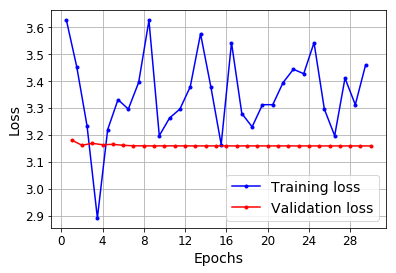

In [36]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

### RNN model

In [37]:
def rnn_model():
    model = Sequential()
    model.add(DenseFeatures(feature_columns=feature_columns.values()))

    # Reshape inputs to pass through RNN layer.
    model.add(Reshape(target_shape=[N_TIME_STEPS, 1]))
    model.add(LSTM(N_TIME_STEPS//2, return_sequences=False))

    model.add(Dense(units=N_TIME_STEPS//4, activation='relu'))
    model.add(Dense(units=N_LABELS, activation='softmax'))

    return model

In [38]:
%%time
LOGDIR = './stock_rnn_trained'

if os.path.exists(LOGDIR):
    shutil.rmtree(LOGDIR)

history = fit_model(model = rnn_model(),
                    batch_size=BATCH_SIZE,
                    num_epochs=NUM_EPOCHS,
                    logdir=LOGDIR)

KeyboardInterrupt: 

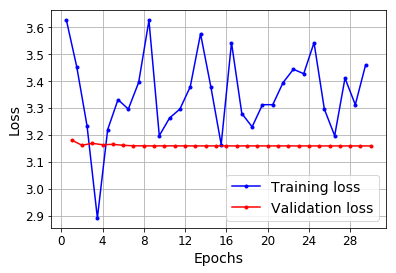

In [39]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

### Multi-layer RNN model

In [40]:
def multi_rnn_model(rnn_hidden_units):
    model = Sequential()
    model.add(DenseFeatures(feature_columns=feature_columns.values()))

    # Reshape inputs to pass through RNN layer.
    model.add(Reshape(target_shape=[N_TIME_STEPS, 1]))

    for layer in rnn_hidden_units[:-1]:
        model.add(LSTM(layer, return_sequences=True))

    model.add(LSTM(rnn_hidden_units[-1], return_sequences=False))
    model.add(Dense(units=N_LABELS, activation="softmax"))

    return model

In [41]:
%%time
LOGDIR = './stock_multi_rnn_trained'

if os.path.exists(LOGDIR):
    shutil.rmtree(LOGDIR)

history = fit_model(model=multi_rnn_model(rnn_hidden_units=[N_TIME_STEPS//2,
                                                            N_TIME_STEPS//4,
                                                            N_TIME_STEPS//8]),
                    batch_size=BATCH_SIZE,
                    num_epochs=NUM_EPOCHS,
                    logdir=LOGDIR)

Epoch 1/30
1/2 [==============>...............] - ETA: 9s - loss: 3.5624 - categorical_accuracy: 0.0100

E1022 20:43:15.830927 139851340015360 ultratb.py:155] Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



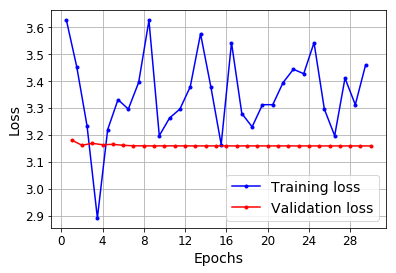

In [42]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

### Combining CNN and RNN architecture

In [43]:
def cnn_rnn_model():
    model = Sequential()
    model.add(DenseFeatures(feature_columns=feature_columns.values()))

    model.add(Reshape(target_shape=[N_TIME_STEPS, 1]))

    model.add(tf.keras.layers.Conv1D(filters=20,
                                     kernel_size=4,
                                     strides=2,
                                     padding="valid",
                                     input_shape=[None, 1]))
    model.add(tf.keras.layers.MaxPool1D(pool_size=2,
                                        strides=None,
                                        padding='valid'))

    model.add(LSTM(N_TIME_STEPS//2, return_sequences=False))
    model.add(Dense(units=N_LABELS, activation="softmax"))

    return model

In [44]:
%%time
LOGDIR = './stock_cnn_rnn_trained'

if os.path.exists(LOGDIR):
    shutil.rmtree(LOGDIR)

history = fit_model(model=cnn_rnn_model(),
                    batch_size=BATCH_SIZE,
                    num_epochs=NUM_EPOCHS,
                    logdir=LOGDIR)

KeyboardInterrupt: 

In [45]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

KeyboardInterrupt: 

In [ ]:
def rnn_cnn_model(rnn_hidden_units):
    model = Sequential()
    model.add(DenseFeatures(feature_columns=feature_columns.values()))

    # Reshape inputs and pass through RNN layer.
    model.add(Reshape(target_shape=[N_TIME_STEPS, 1]))
    for layer in rnn_hidden_units:
        model.add(LSTM(layer, return_sequences=True))

    # Apply 1d convolution to RNN outputs.
    model.add(tf.keras.layers.Conv1D(filters=20,
                                     kernel_size=4,
                                     strides=2,
                                     padding="valid"))
    model.add(tf.keras.layers.MaxPool1D(pool_size=2,
                                        strides=None,
                                        padding='valid'))

    # Flatten the convolution output and pass through DNN.
    model.add(tf.keras.layers.Flatten())
    model.add(Dense(units=N_TIME_STEPS//8), activation="relu")
    model.add(Dense(units=N_LABELS, activation="softmax"))

    return model

In [ ]:
%%time
LOGDIR = './stock_rnn_cnn_trained'

if os.path.exists(LOGDIR):
    shutil.rmtree(LOGDIR)

history = fit_model(model=rnn_cnn_model(rnn_hidden_units=[N_TIME_STEPS//2,
                                                          N_TIME_STEPS//4]),
                    batch_size=BATCH_SIZE,
                    num_epochs=NUM_EPOCHS,
                    logdir=LOGDIR)

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()